In [25]:
# LLM Translation Pipeline with Glossary-Based Retrieval  
"""
This notebook demonstrates a multi-model translation pipeline using glossary term retrieval and LLM prompting.  
It compares translation quality *with vs. without* retrieval across multiple models (OpenAI GPT-4o-mini, Groq Llama-3.1-8B, and Groq Llama-3.3-70B).
"""

'\nThis notebook demonstrates a multi-model translation pipeline using glossary term retrieval and LLM prompting.  \nIt compares translation quality *with vs. without* retrieval across multiple models (OpenAI GPT-4o-mini, Groq Llama-3.1-8B, and Groq Llama-3.3-70B).\n'

In [26]:
%pip install python-dotenv

import os, sys, time, json, hashlib, random
import pandas as pd, numpy as np
from dotenv import load_dotenv
from openai import RateLimitError, APIError
from tqdm import tqdm
import tiktoken

# Load .env
base = os.getcwd()
if os.path.basename(base).lower() == "notebooks":
    base = os.path.dirname(base)
env_path = os.path.join(base, ".env")
load_dotenv(env_path)

# Project paths
BASE = os.getcwd()
if os.path.basename(BASE).lower() == "notebooks":
    BASE = os.path.dirname(BASE)
DATA = os.path.join(BASE, "data")
SRC  = os.path.join(BASE, "src")
if SRC not in sys.path:
    sys.path.append(SRC)

print("BASE:", BASE)
print("DATA:", DATA)
print("SRC:", SRC)


Note: you may need to restart the kernel to use updated packages.
BASE: e:\Data\translation-pipeline
DATA: e:\Data\translation-pipeline\data
SRC: e:\Data\translation-pipeline\src


In [27]:
from retrieval import build_glossary_corpus, best_k_terms, select_constraints
from prompting import make_prompt, restore_spans
from evaluation import term_adherence, basic_metrics
from models import generate


In [28]:
from sentence_transformers import SentenceTransformer

glossary = pd.read_csv(os.path.join(DATA, "glossary.csv"))
samples = pd.read_csv(os.path.join(DATA, "samples_en.csv"))
print(f"Glossary rows: {len(glossary)}")
print(f"Sample rows: {len(samples)}")

corpora = {t: build_glossary_corpus(glossary, t) for t in ["fr", "it", "ja"]}
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
lang_label_map = {"fr": "French", "it": "Italian", "ja": "Japanese"}
print("Prepared corpora:", list(corpora.keys()))


Glossary rows: 9
Sample rows: 30
Prepared corpora: ['fr', 'it', 'ja']


In [ ]:
# Translator with cache, budget guard, and multi-model routing via src/models.py

import os, json, hashlib, time, random
import tiktoken
from openai import RateLimitError, APIError
from models import generate  # router

# Configure costs and budget 
INPUT_COST_PER_M  = globals().get("INPUT_COST_PER_M", 0.15)   # $ / 1M input tokens
OUTPUT_COST_PER_M = globals().get("OUTPUT_COST_PER_M", 0.60)  # $ / 1M output tokens
BUDGET_DOLLARS    = globals().get("BUDGET_DOLLARS", 5.00)

# Tokenizer and spending state
enc = tiktoken.get_encoding("cl100k_base")
spent_dollars = globals().get("spent_dollars", 0.0)

# On-disk cache 
CACHE_PATH = os.path.join(DATA, "cache.jsonl")
_cache = globals().get("_cache", {})

def _load_cache():
    if os.path.exists(CACHE_PATH) and not _cache:
        with open(CACHE_PATH, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    rec = json.loads(line)
                    _cache[rec["key"]] = rec
                except:
                    pass

def _save_cache_item(key, value):
    with open(CACHE_PATH, "a", encoding="utf-8") as f:
        f.write(json.dumps({"key": key, **value}, ensure_ascii=False) + "\n")

def _cache_key(source, tgt_lang_label, constraints, model_name):
    payload = {
        "src": source,
        "tgt": tgt_lang_label,
        "constraints": constraints,
        "model": model_name,
    }
    s = json.dumps(payload, sort_keys=True, ensure_ascii=False)
    return hashlib.md5(s.encode("utf-8")).hexdigest()

def _estimate_cost_usd(prompt_text: str, completion_text: str = "") -> float:
    in_tok = len(enc.encode(prompt_text))
    out_tok = len(enc.encode(completion_text)) if completion_text else 0
    return (in_tok/1_000_000.0)*INPUT_COST_PER_M + (out_tok/1_000_000.0)*OUTPUT_COST_PER_M

def translate_llm_safe(source: str, tgt_lang_label: str, constraints, model_name: str,
                       temperature: float = 0.2, max_retries: int = 5, base_sleep: float = 0.8):
    """
    Returns (hypothesis, latency_seconds).
    model_name must be present in models.MODEL_ROUTING (e.g., 'gpt-4o-mini', 'llama3-8b', 'llama3-70b').
    """
    global spent_dollars
    _load_cache()

    prompt, spans = make_prompt(source, tgt_lang_label, constraints)
    key = _cache_key(source, tgt_lang_label, constraints, model_name)

    # Cache hit
    if key in _cache:
        rec = _cache[key]
        hyp = restore_spans(rec["hyp"], spans)
        return hyp, rec["latency_s"]

    # Budget guard on input estimate
    est_in_cost = _estimate_cost_usd(prompt, "")
    if spent_dollars + est_in_cost > BUDGET_DOLLARS:
        raise RuntimeError(f"Budget guard tripped at ${spent_dollars:.2f}/${BUDGET_DOLLARS:.2f}. Reduce rows or raise budget.")

    attempt = 0
    while True:
        try:
            start = time.time()
            hyp_raw = generate(model_name, messages=[{"role": "user", "content": prompt}], temperature=temperature)
            hyp = restore_spans(hyp_raw.strip(), spans)
            latency = time.time() - start

            # Account for input + output
            spent_dollars += _estimate_cost_usd(prompt, hyp)

            # Persist
            value = {"hyp": hyp, "latency_s": latency}
            _cache[key] = value
            _save_cache_item(key, value)

            time.sleep(0.2)  # small throttle
            return hyp, latency

        except (RateLimitError, APIError):
            attempt += 1
            if attempt > max_retries:
                raise
            time.sleep(base_sleep * (2 ** (attempt - 1)) + random.uniform(0, 0.4))


In [ ]:
# Sanity check: run a single sentence through one model to verify everything
row = samples.iloc[0]  
src = row["src"]
tgt = row["pair"].split("-")[-1]      # 'fr', 'it', or 'ja'
tgt_label = lang_label_map[tgt]

# Retrieval
docs = corpora[tgt]
idxs = best_k_terms(src, docs, embeddings=embedder, k=3)
cons = select_constraints(glossary, idxs, tgt)

# Model to sanity-test
model_name = "gpt-4o-mini"  

hyp_with,  lat_with = translate_llm_safe(src, tgt_label, cons,            model_name=model_name)
hyp_without, lat_wo = translate_llm_safe(src, tgt_label, constraints=[],  model_name=model_name)

print("MODEL:", model_name)
print("SOURCE:", src)
print("TARGET:", tgt_label)
print("\nWITH retrieval:")
print(hyp_with)
print(f"(latency: {lat_with:.2f}s)")
print("\nWITHOUT retrieval:")
print(hyp_without)
print(f"(latency: {lat_wo:.2f}s)")


MODEL: gpt-4o-mini
SOURCE: Enter your email address to continue.
TARGET: French

WITH retrieval:
Entrez votre adresse e-mail pour continuer.
(latency: 1.21s)

WITHOUT retrieval:
Entrez votre adresse e-mail pour continuer.
(latency: 0.71s)


In [36]:
# Batch comparison over 50 rows: gpt-4o-mini (OpenAI), llama3-8b (Groq), llama3-70b (Groq)

from tqdm import tqdm

MODELS = ["gpt-4o-mini", "llama3-8b", "llama3-70b"]

subset = samples.head(50)   # ensure we process 50 rows
all_records = []

for model_name in MODELS:
    print(f"\nRunning model: {model_name}")
    model_records = []

    for _, row in tqdm(subset.iterrows(), total=len(subset)):
        src = row["src"]
        tgt = row["pair"].split("-")[-1]
        tgt_label = lang_label_map[tgt]

        # retrieval
        docs = corpora[tgt]
        idxs = best_k_terms(src, docs, embeddings=embedder, k=2)
        cons = select_constraints(glossary, idxs, tgt)

        # with and without retrieval
        hyp_with, lat_with = translate_llm_safe(src, tgt_label, cons,            model_name=model_name)
        hyp_wo,   lat_wo   = translate_llm_safe(src, tgt_label, constraints=[],  model_name=model_name)

        ta_with = term_adherence(hyp_with, cons)
        ta_wo   = term_adherence(hyp_wo,   cons)

        model_records.append({
            "model": model_name,
            "id": row["id"],
            "pair": row["pair"],
            "source": src,
            "hyp_with": hyp_with,
            "hyp_without": hyp_wo,
            "term_acc_with": ta_with,
            "term_acc_without": ta_wo,
            "lat_with_s": lat_with,
            "lat_without_s": lat_wo,
        })

    df_m = pd.DataFrame(model_records)
    out_csv = os.path.join(DATA, f"results_{model_name.replace('/', '_')}_n50.csv")
    df_m.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    all_records.extend(model_records)

# Combined results for all models
results_all = pd.DataFrame(all_records)
combined_csv = os.path.join(DATA, "results_all_models_n50.csv")
results_all.to_csv(combined_csv, index=False)
print("Saved combined:", combined_csv)

# Quick summaries
print("\nMean term adherence by model (n=50 each):")
display(results_all.groupby("model")[["term_acc_with","term_acc_without"]].mean())

print("\nMean term adherence by model and language (n=50 total):")
display(results_all.groupby(["model","pair"])[["term_acc_with","term_acc_without"]].mean())



Running model: gpt-4o-mini


100%|██████████| 50/50 [01:43<00:00,  2.06s/it]


Saved: e:\Data\translation-pipeline\data\results_gpt-4o-mini_n50.csv

Running model: llama3-8b


100%|██████████| 50/50 [02:26<00:00,  2.93s/it]


Saved: e:\Data\translation-pipeline\data\results_llama3-8b_n50.csv

Running model: llama3-70b


100%|██████████| 50/50 [04:22<00:00,  5.25s/it]

Saved: e:\Data\translation-pipeline\data\results_llama3-70b_n50.csv
Saved combined: e:\Data\translation-pipeline\data\results_all_models_n50.csv

Mean term adherence by model (n=50 each):


,term_acc_with,term_acc_without
model,,
gpt-4o-mini,0.36,0.25
llama3-70b,0.31,0.21
llama3-8b,0.31,0.16



Mean term adherence by model and language (n=50 total):


term_acc_with  term_acc_without
model       pair                                  
gpt-4o-mini en-fr       0.421053          0.342105
            en-it       0.281250          0.156250
            en-ja       0.366667          0.233333
llama3-70b  en-fr       0.342105          0.315789
            en-it       0.218750          0.156250
            en-ja       0.366667          0.133333
llama3-8b   en-fr       0.368421          0.210526
            en-it       0.281250          0.156250
            en-ja       0.266667          0.100000

In [37]:
import time

ts = time.strftime('%Y%m%d_%H%M%S')

# 3A) Per-model HTML reports
for m in MODELS:
    dfm = results_all[results_all["model"] == m].copy()
    html_path = os.path.join(DATA, f"side_by_side_{m.replace('/','_')}_n50_{ts}.html")

    html_header = """
    <html><head>
    <style>
    body { font-family: Arial, sans-serif; margin: 20px; }
    table { border-collapse: collapse; width: 100%; }
    th, td { border: 1px solid #ccc; padding: 8px; vertical-align: top; }
    th { background-color: #f2f2f2; }
    </style></head><body>
    """
    html_title = f"<h2>Translation Comparison (With vs Without Retrieval) — {m}</h2>"
    table_head = "<table><tr><th>ID</th><th>Language Pair</th><th>Source</th><th>With Retrieval</th><th>Without Retrieval</th></tr>"
    rows = []
    for _, r in dfm.iterrows():
        rows.append(
            f"<tr><td>{r.id}</td><td>{r.pair}</td><td>{r.source}</td><td>{r.hyp_with}</td><td>{r.hyp_without}</td></tr>"
        )
    html_footer = "</table></body></html>"

    with open(html_path, "w", encoding="utf-8") as f:
        f.write(html_header + html_title + table_head + "".join(rows) + html_footer)

    print("Saved per-model HTML:", html_path)

# 3B) Combined HTML across all models
html_path_all = os.path.join(DATA, f"side_by_side_all_models_n50_{ts}.html")

html_header = """
<html><head>
<style>
body { font-family: Arial, sans-serif; margin: 20px; }
table { border-collapse: collapse; width: 100%; }
th, td { border: 1px solid #ccc; padding: 8px; vertical-align: top; }
th { background-color: #f2f2f2; }
</style></head><body>
"""
html_title = "<h2>Translation Comparison (With vs Without Retrieval) — All Models</h2>"
table_head = "<table><tr><th>Model</th><th>ID</th><th>Language Pair</th><th>Source</th><th>With Retrieval</th><th>Without Retrieval</th></tr>"
rows = []
for _, r in results_all.iterrows():
    rows.append(
        f"<tr><td>{r.model}</td><td>{r.id}</td><td>{r.pair}</td><td>{r.source}</td><td>{r.hyp_with}</td><td>{r.hyp_without}</td></tr>"
    )
html_footer = "</table></body></html>"

with open(html_path_all, "w", encoding="utf-8") as f:
    f.write(html_header + html_title + table_head + "".join(rows) + html_footer)

print("Saved combined HTML:", html_path_all)


Saved per-model HTML: e:\Data\translation-pipeline\data\side_by_side_gpt-4o-mini_n50_20251014_002631.html
Saved per-model HTML: e:\Data\translation-pipeline\data\side_by_side_llama3-8b_n50_20251014_002631.html
Saved per-model HTML: e:\Data\translation-pipeline\data\side_by_side_llama3-70b_n50_20251014_002631.html
Saved combined HTML: e:\Data\translation-pipeline\data\side_by_side_all_models_n50_20251014_002631.html


In [38]:
# Per-model summary
summary_model = results_all.groupby("model")[["term_acc_with","term_acc_without","lat_with_s","lat_without_s"]].mean().reset_index()
summary_csv = os.path.join(DATA, f"summary_by_model_n50_{ts}.csv")
summary_model.to_csv(summary_csv, index=False)
print("Saved summary:", summary_csv)
display(summary_model)

# Per-model, per-language summary
summary_model_lang = results_all.groupby(["model","pair"])[["term_acc_with","term_acc_without","lat_with_s","lat_without_s"]].mean().reset_index()
summary_ml_csv = os.path.join(DATA, f"summary_by_model_language_n50_{ts}.csv")
summary_model_lang.to_csv(summary_ml_csv, index=False)
print("Saved summary by model and language:", summary_ml_csv)
display(summary_model_lang)


Saved summary: e:\Data\translation-pipeline\data\summary_by_model_n50_20251014_002631.csv


,model,term_acc_with,term_acc_without,lat_with_s,lat_without_s
0,gpt-4o-mini,0.36,0.25,1.376952,1.211499
1,llama3-70b,0.31,0.21,1.879641,1.868458
2,llama3-8b,0.31,0.16,1.524870,2.066580


Saved summary by model and language: e:\Data\translation-pipeline\data\summary_by_model_language_n50_20251014_002631.csv


,model,pair,term_acc_with,term_acc_without,lat_with_s,lat_without_s
0,gpt-4o-mini,en-fr,0.421053,0.342105,1.264941,1.845590
1,gpt-4o-mini,en-it,0.281250,0.156250,1.180823,0.758619
2,gpt-4o-mini,en-ja,0.366667,0.233333,1.728038,0.891389
3,llama3-70b,en-fr,0.342105,0.315789,1.263774,1.399020
4,llama3-70b,en-it,0.218750,0.156250,1.481054,2.816360
5,llama3-70b,en-ja,0.366667,0.133333,3.084898,1.451985
6,llama3-8b,en-fr,0.368421,0.210526,1.445053,1.986498
7,llama3-8b,en-it,0.281250,0.156250,1.621024,2.082973
8,llama3-8b,en-ja,0.266667,0.100000,1.523408,2.150531


Loaded: e:\Data\translation-pipeline\data\summary_by_model_language_n50_20251014_002631.csv


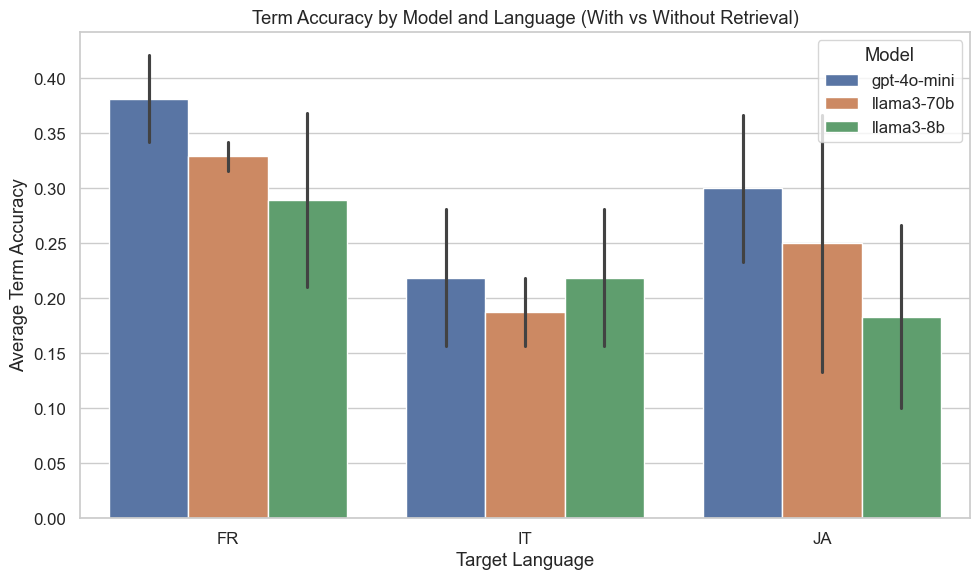

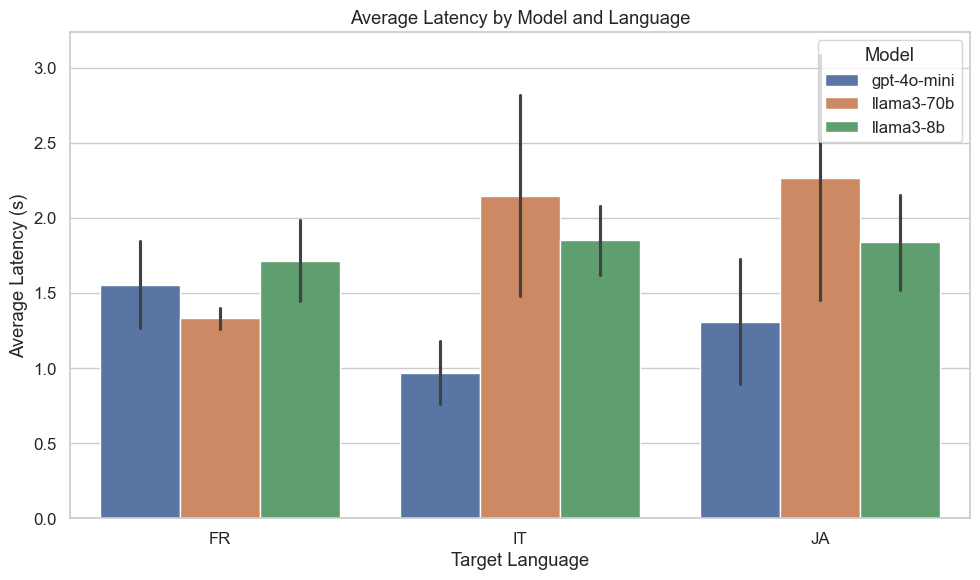

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Load the summary file 
summary_path = [f for f in os.listdir(DATA) if f.startswith("summary_by_model_language_n50_") and f.endswith(".csv")][-1]
summary_path = os.path.join(DATA, summary_path)
print("Loaded:", summary_path)

df = pd.read_csv(summary_path)
df["Language"] = df["pair"].str.split("-").str[-1].str.upper()

# Set style
sns.set(style="whitegrid", font_scale=1.1)

# Plot 1: Term Accuracy (With vs Without Retrieval)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df.melt(id_vars=["model", "Language"], value_vars=["term_acc_with", "term_acc_without"], 
                 var_name="Mode", value_name="Term Accuracy"),
    x="Language", y="Term Accuracy", hue="model"
)
plt.title("Term Accuracy by Model and Language (With vs Without Retrieval)")
plt.xlabel("Target Language")
plt.ylabel("Average Term Accuracy")
plt.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()

# Plot 2: Latency (With vs Without Retrieval)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df.melt(id_vars=["model", "Language"], value_vars=["lat_with_s", "lat_without_s"], 
                 var_name="Mode", value_name="Latency (s)"),
    x="Language", y="Latency (s)", hue="model"
)
plt.title("Average Latency by Model and Language")
plt.xlabel("Target Language")
plt.ylabel("Average Latency (s)")
plt.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()


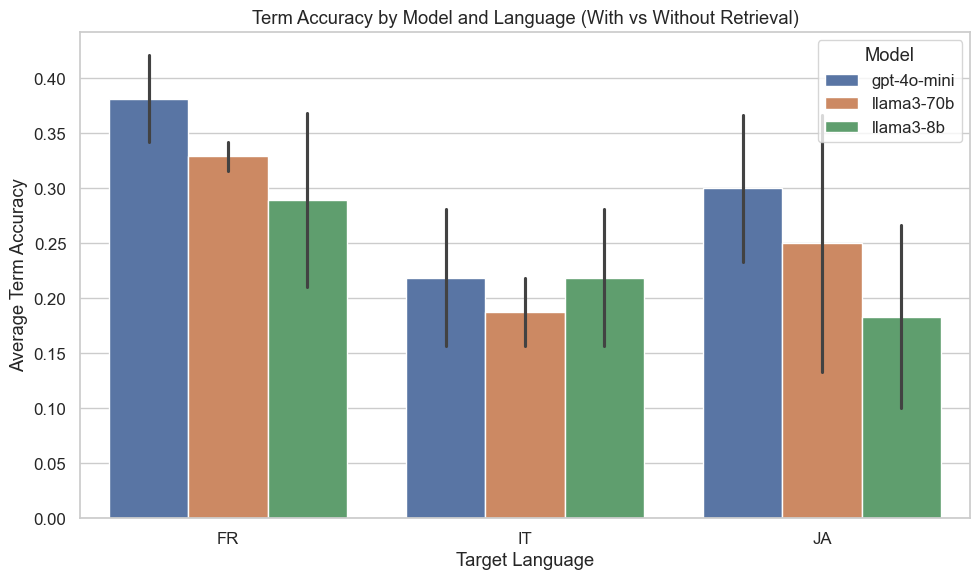

Saved: e:\Data\translation-pipeline\data\figures\term_accuracy_by_model_language_20251014_011334.png


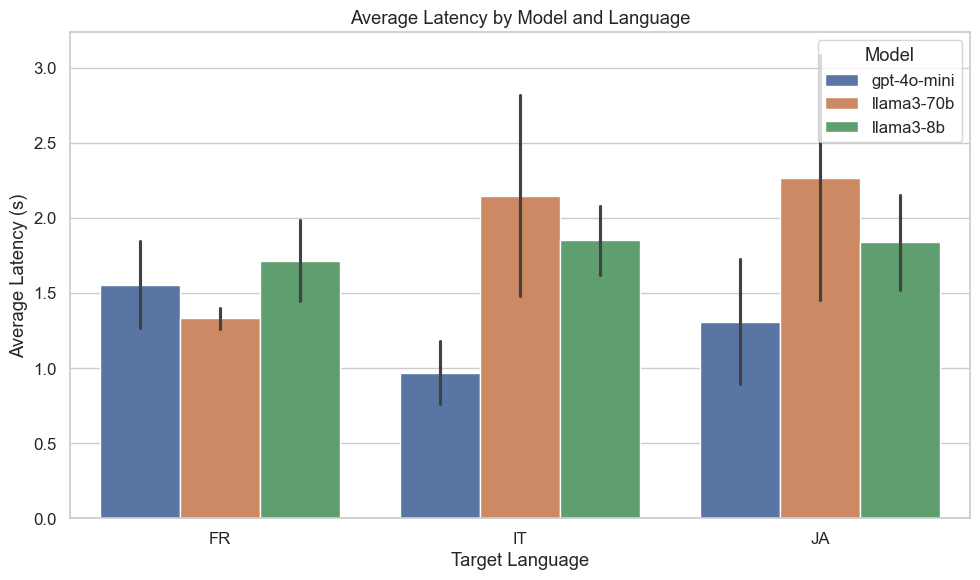

Saved: e:\Data\translation-pipeline\data\figures\latency_by_model_language_20251014_011334.png


In [ ]:
import os, time
import matplotlib.pyplot as plt


# Create a figures directory
figdir = os.path.join(DATA, "figures")
os.makedirs(figdir, exist_ok=True)

ts = time.strftime('%Y%m%d_%H%M%S')

# ----- Rebuild Plot 1: Term Accuracy by Model and Language (With vs Without) -----
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(
    data=df.melt(
        id_vars=["model", "Language"],
        value_vars=["term_acc_with", "term_acc_without"],
        var_name="Mode",
        value_name="Term Accuracy"
    ),
    x="Language", y="Term Accuracy", hue="model"
)
plt.title("Term Accuracy by Model and Language (With vs Without Retrieval)")
plt.xlabel("Target Language")
plt.ylabel("Average Term Accuracy")
plt.legend(title="Model", loc="upper right")
plt.tight_layout()

acc_path = os.path.join(figdir, f"term_accuracy_by_model_language_{ts}.png")
plt.gcf().savefig(acc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", acc_path)

# ----- Rebuild Plot 2: Latency by Model and Language -----
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(
    data=df.melt(
        id_vars=["model", "Language"],
        value_vars=["lat_with_s", "lat_without_s"],
        var_name="Mode",
        value_name="Latency (s)"
    ),
    x="Language", y="Latency (s)", hue="model"
)
plt.title("Average Latency by Model and Language")
plt.xlabel("Target Language")
plt.ylabel("Average Latency (s)")
plt.legend(title="Model", loc="upper right")
plt.tight_layout()

lat_path = os.path.join(figdir, f"latency_by_model_language_{ts}.png")
plt.gcf().savefig(lat_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", lat_path)
